In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [2]:
# Define the data augmentation and preprocessing pipeline
data_aug = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0, 1] range
    horizontal_flip=True,               # Randomly flip images horizontally
    fill_mode='nearest',                # Fill in missing pixels after transformations using nearest neighbor interpolation
)

In [3]:
directory = 'C:/Users/psxah20/Desktop/Dissertation/Predictive_Images_Combined_Only/'
img_width = img_height = 96  # Updated to match the paper's input size
batch_size = 224

In [4]:
train_data = data_aug.flow_from_directory(
    directory + 'Train/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',  # changed to 'categorical' for multiclass classification
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
)

test_data = data_aug.flow_from_directory(
    directory + 'Test/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
)

Found 9376 images belonging to 6 classes.
Found 1046 images belonging to 6 classes.


# Creating CNN model

In [5]:
def create_cnn_model(input_shape, num_cnn_layers=3, 
                     num_dense_layers=2, base_filters=16, 
                     dense_units=128, dropout_rate=0.5, 
                     compile_params=['adam', 'binary_crossentropy', ['accuracy']], num_classes=6):
    model = Sequential()

    # Input layer
    model.add(Conv2D(filters=base_filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Hidden CNN Layers
    filters = base_filters * 2
    for i in range(num_cnn_layers):
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        filters *= 2  # Double the number of filters for each subsequent CNN layer

    model.add(Flatten())

    # ANN Layers
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))

    # Hidden ANN Layers
    for i in range(num_dense_layers):
        dense_units //= 2  # Halve the units for each subsequent dense layer
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    # Output layer
    model.add(Dense(units=num_classes, activation='softmax'))
  
    optimizer, loss, metrics = compile_params
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [6]:
input_shape = (img_width, img_height, 3)  # Updated input shape
compile_params = ['adam', 'categorical_crossentropy', ['accuracy']]
num_classes = len(train_data.class_indices)
model = create_cnn_model(input_shape, compile_params=compile_params, num_classes=num_classes)

c:\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697,926 (2.66 MB)

 Trainable params: 697,926 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping

In [8]:
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
early_stop_val_accuracy = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Model CheckPoint

In [9]:
# Model checkpoint to save the best model based on validation accuracy using .h5 format
model_checkpoint = ModelCheckpoint('synthetic_data_cnn.keras', monitor='val_accuracy', save_best_only=True)

# Model Training

In [ ]:
# Compile the model with the optimizations
results = model.fit(train_data, epochs=100, verbose=1, 
                    callbacks=[early_stop_val_loss, early_stop_val_accuracy, reduce_lr, model_checkpoint],
                    validation_data=test_data)

# Metrics

Creating dataframe to get the history(Loss, accuracy) of trained data

In [10]:
metric = pd.DataFrame(model.history.history)
metric

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.652184,2.034895,0.658621,1.391518,0.0010
1,0.710680,1.575040,0.718621,1.236741,0.0010
2,0.755340,1.326667,0.765862,1.089936,0.0010
3,0.790583,1.198719,0.795862,0.905449,0.0010
4,0.825825,1.057255,0.828621,0.817595,0.0010
5,0.856602,0.917202,0.858621,0.756612,0.0010
6,0.875534,0.793995,0.878759,0.693914,0.0002
7,0.887379,0.680227,0.888862,0.657796,0.0002
8,0.897087,0.636753,0.898862,0.634043,0.0002
9,0.914272,0.590269,0.915862,0.546093,0.0002


Let's Visualize metrics

<Axes: >

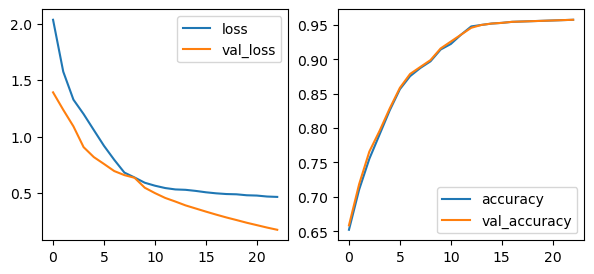

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,3))
metric[['loss', 'val_loss']].plot(ax=axes[0])
metric[['accuracy', 'val_accuracy']].plot(ax=axes[1])

# Load Best Weights

In [ ]:
model = load_model('synthetic_data_cnn.keras')

# Prediction

Predict on Test Data

In [ ]:
pred = model.predict(test_data)
pred

In [3]:
pred = np.argmax(pred, axis=1)
print(classification_report(test_data.classes, pred))

                Precision Recall  F1-Score  Support
0        pain_1      0.99   0.98      0.99      220
1        pain_2      0.97   0.99      0.98      300
2        pain_3      0.98   0.97      0.98      200
3        pain_4      0.98   0.98      0.98      180
4        pain_5      0.97   0.98      0.98      214
5      Accuracy                       0.98     1114
6     Macro Avg      0.98   0.98      0.98     1114
7  Weighted Avg      0.98   0.98      0.98     1114
